https://osanseviero.github.io/hackerllama/blog/posts/sentence_embeddings/ (ref)

In [ ]:
!pip install sentence_transformers

In [2]:
from sentence_transformers import SentenceTransformer, util

In [ ]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [4]:
sentences = ["The weather today is beautiful", "It's raining!", "Dogs are awesome"]
embeddings = model.encode(sentences)
embeddings.shape

(3, 384)

In [5]:
first_embedding = model.encode('today is sunny day')
for embedding, sentence in zip(embeddings, sentences):
  cos_score = util.pytorch_cos_sim(first_embedding, embedding)
  print(f"score:{cos_score} ({sentence})")

score:tensor([[0.7190]]) (The weather today is beautiful)
score:tensor([[0.3898]]) (It's raining!)
score:tensor([[0.1043]]) (Dogs are awesome)


In [6]:
faq = {
    "How do I get a replacement Medicare card?": "If your Medicare card was lost, stolen, or destroyed, you can request a replacement online at Medicare.gov.",
    "How do I sign up for Medicare?": "If you already get Social Security benefits, you do not need to sign up for Medicare. We will automatically enroll you in Original Medicare (Part A and Part B) when you become eligible. We will mail you the information a few months before you become eligible.",
    "What are Medicare late enrollment penalties?": "In most cases, if you don’t sign up for Medicare when you’re first eligible, you may have to pay a higher monthly premium. Find more information at https://faq.ssa.gov/en-us/Topic/article/KA-02995",
    "Will my Medicare premiums be higher because of my higher income?": "Some people with higher income may pay a larger percentage of their monthly Medicare Part B and prescription drug costs based on their income. We call the additional amount the income-related monthly adjustment amount.",
    "What is Medicare and who can get it?": "Medicare is a health insurance program for people age 65 or older. Some younger people are eligible for Medicare including people with disabilities, permanent kidney failure and amyotrophic lateral sclerosis (Lou Gehrig’s disease or ALS). Medicare helps with the cost of health care, but it does not cover all medical expenses or the cost of most long-term care.",
}

In [7]:
corpus_embeddings = model.encode(list(faq.keys()))
print(corpus_embeddings.shape)

(5, 384)


In [8]:
user_question = "Do I need to pay more after a raise?"
user_question_embedding = model.encode(user_question)

In [9]:
similarities = util.semantic_search(user_question_embedding, corpus_embeddings, top_k=5)
similarities

[[{'corpus_id': 3, 'score': 0.4642062783241272},
  {'corpus_id': 4, 'score': 0.11628524214029312},
  {'corpus_id': 2, 'score': 0.09916316717863083},
  {'corpus_id': 1, 'score': 0.09463591873645782},
  {'corpus_id': 0, 'score': 0.07962210476398468}]]

In [10]:
for i, result in enumerate(similarities[0]):
  corpus_id = result['corpus_id']
  question = list(faq.keys())[corpus_id]
  answer = list(faq.values())[corpus_id]
  score = result['score']
  print(f"score:{score}\nquestion:{question}\nanswer:{answer}\n")

score:0.4642062783241272
question:Will my Medicare premiums be higher because of my higher income?
answer:Some people with higher income may pay a larger percentage of their monthly Medicare Part B and prescription drug costs based on their income. We call the additional amount the income-related monthly adjustment amount.

score:0.11628524214029312
question:What is Medicare and who can get it?
answer:Medicare is a health insurance program for people age 65 or older. Some younger people are eligible for Medicare including people with disabilities, permanent kidney failure and amyotrophic lateral sclerosis (Lou Gehrig’s disease or ALS). Medicare helps with the cost of health care, but it does not cover all medical expenses or the cost of most long-term care.

score:0.09916316717863083
question:What are Medicare late enrollment penalties?
answer:In most cases, if you don’t sign up for Medicare when you’re first eligible, you may have to pay a higher monthly premium. Find more information

In [11]:
from transformers import AutoModel, AutoTokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

In [13]:
text = "The king and the queen are happy."
t = tokenizer.tokenize(text,add_special_tokens=True)
print(len(t))
t

10


['[CLS]', 'the', 'king', 'and', 'the', 'queen', 'are', 'happy', '.', '[SEP]']

In [14]:
encoded_input = tokenizer(text, return_tensors="pt")
output = model(**encoded_input)
output['last_hidden_state'].shape

torch.Size([1, 10, 768])

In [15]:
king_embedding = output['last_hidden_state'][0][2]
queen_embedding = output['last_hidden_state'][0][5]
print(f'score:{util.pytorch_cos_sim(king_embedding, queen_embedding)} ')

score:tensor([[0.7921]], grad_fn=<MmBackward0>) 


In [16]:
happy_embedding = output.last_hidden_state[0][7]  # happy
util.pytorch_cos_sim(king_embedding, happy_embedding)

tensor([[0.5239]], grad_fn=<MmBackward0>)

In [17]:
text = "The angry and unhappy king"
encoded_input = tokenizer(text, return_tensors="pt")
output = model(**encoded_input)
output["last_hidden_state"].shape


torch.Size([1, 7, 768])

In [18]:
tokenizer.tokenize(text, add_special_tokens=True)

['[CLS]', 'the', 'angry', 'and', 'unhappy', 'king', '[SEP]']

In [19]:
king_embedding_2 = output["last_hidden_state"][0][5]
util.pytorch_cos_sim(king_embedding, king_embedding_2)

tensor([[0.5740]], grad_fn=<MmBackward0>)

In [20]:
tokenizer.tokenize('tokenization')

['token', '##ization']

In [21]:
text = "this is about tokenization"
encoded_input = tokenizer(text, return_tensors="pt")
output = model(**encoded_input)

In [22]:
tokenizer.tokenize(text, add_special_tokens=True)

['[CLS]', 'this', 'is', 'about', 'token', '##ization', '[SEP]']

In [23]:
word_token_indices = [4, 5]
word_embeddings = output["last_hidden_state"][0, word_token_indices]
word_embeddings.shape

torch.Size([2, 768])

In [24]:
import torch
torch.mean(word_embeddings, dim=0).shape

torch.Size([768])

In [25]:
def get_word_embedding(text, word):
    encoded_input = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        output = model(**encoded_input)

    word_ids = tokenizer.encode(
        word, add_special_tokens=False
    )
    word_token_indices = [
        i
        for i, token_id in enumerate(encoded_input["input_ids"][0])
        if token_id in word_ids
    ]

    word_embeddings = output["last_hidden_state"][0, word_token_indices]
    return torch.mean(word_embeddings, dim=0)

In [26]:
text = "this is about tokenization"
get_word_embedding(text, 'tokenization').shape

torch.Size([768])

In [27]:
torch.allclose(torch.mean(word_embeddings, dim=0), get_word_embedding(text, 'tokenization'))

True

In [28]:
util.pytorch_cos_sim(
    get_word_embedding("The king is angry", "king"),
    get_word_embedding("The queen is angry", "queen"),
)

tensor([[0.8564]])

In [29]:
util.pytorch_cos_sim(
    get_word_embedding("The king is happy", "king"),
    get_word_embedding("The queen is angry", "queen"),
)

tensor([[0.8273]])

In [30]:
util.pytorch_cos_sim(
    get_word_embedding("The king and the queen are happy.", "king"),
    get_word_embedding("The angry and unhappy king", "king"),
)

tensor([[0.5740]])

In [31]:
util.pytorch_cos_sim(
    get_word_embedding("The river bank", "bank"),
    get_word_embedding("The savings bank", "bank"),
)

tensor([[0.7587]])

In [32]:
encode_input = tokenizer('Thisn is an  example sentence', return_tensors='pt')
model_output = model(**encoded_input)
sentence_embedding = model_output['last_hidden_state'][:, 0, :]
sentence_embedding.shape

torch.Size([1, 768])

In [33]:
def cls_pooling(model_output):
    return model_output["last_hidden_state"][:, 0, :]

def get_sentence_embedding(text):
    encoded_input = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**encoded_input)
    return cls_pooling(model_output)

In [34]:
embeddings = [get_sentence_embedding(sentence) for sentence in sentences]
query_embedding = get_sentence_embedding("Today is a sunny day")
for embedding, sentence in zip(embeddings, sentences):
    similarity = util.pytorch_cos_sim(query_embedding, embedding)
    print(similarity, sentence)

tensor([[0.9261]]) The weather today is beautiful
tensor([[0.8903]]) It's raining!
tensor([[0.9317]]) Dogs are awesome


In [35]:
def cls_pooling(model_output):
    return model.pooler(model_output["last_hidden_state"])  # we changed this


embeddings = [get_sentence_embedding(sentence) for sentence in sentences]
query_embedding = get_sentence_embedding("Today is a sunny day")
for embedding, sentence in zip(embeddings, sentences):
    similarity = util.pytorch_cos_sim(query_embedding, embedding)
    print(similarity, sentence)

tensor([[0.9673]], grad_fn=<MmBackward0>) The weather today is beautiful
tensor([[0.9029]], grad_fn=<MmBackward0>) It's raining!
tensor([[0.8930]], grad_fn=<MmBackward0>) Dogs are awesome


In [36]:
tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")
encoded_input = tokenizer("Today is a sunny day", return_tensors="pt")
model_output = model(**encoded_input)

In [37]:
token_embeddings = model_output["last_hidden_state"]
token_embeddings.shape

torch.Size([1, 7, 384])

In [38]:
mean_embedding = torch.mean(token_embeddings, dim=1)
mean_embedding.shape

torch.Size([1, 384])

In [39]:
import torch.nn.functional as F
normalized_embedding = F.normalize(mean_embedding)
normalized_embedding.shape

torch.Size([1, 384])

In [40]:
def mean_pooling(model_output):
    return torch.mean(model_output["last_hidden_state"], dim=1)

def get_sentence_embedding(text):
    encoded_input = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        model_output = model(**encoded_input)
    sentence_embeddings = mean_pooling(model_output)
    return F.normalize(sentence_embeddings)

get_sentence_embedding("Today is a sunny day").shape

torch.Size([1, 384])

In [41]:
def mean_pooling(model_output, attention_mask):
  token_embeddings = model_output['last_hidden_state']
  input_mask_expanded = (
      attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
  )
  return torch.sum(token_embeddings, 1)/torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [42]:
def get_sentence_embedding(sentences):
  encoded_input = tokenizer(
      sentences, padding=True, truncation=True, return_tensors="pt"
  )
  with torch.no_grad():
    model_output = model(**encoded_input)

  sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

  return  F.normalize(sentence_embeddings)

In [43]:
query_embedding = get_sentence_embedding("Today is a sunny day")[0]
query_embedding.shape

torch.Size([384])

In [44]:
embeddings = [get_sentence_embedding(sentence) for sentence in sentences]
for embedding, sentence in zip(embeddings, sentences):
    similarity = util.pytorch_cos_sim(query_embedding, embedding)
    print(similarity, sentence)

tensor([[0.7344]]) The weather today is beautiful
tensor([[0.4180]]) It's raining!
tensor([[0.1060]]) Dogs are awesome


In [45]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
query_embedding = model.encode("Today is a sunny day")
embeddings = model.encode(sentences)
for embedding, sentence in zip(embeddings, sentences):
    similarity = util.pytorch_cos_sim(query_embedding, embedding)
    print(similarity, sentence)

tensor([[0.7344]]) The weather today is beautiful
tensor([[0.4180]]) It's raining!
tensor([[0.1060]]) Dogs are awesome


In [ ]:
!pip install datasets

In [47]:
from datasets import load_dataset

In [48]:
dataset = load_dataset('quora', split='train')
dataset

Generating train split:   0%|          | 0/404290 [00:00<?, ? examples/s]

Dataset({
    features: ['questions', 'is_duplicate'],
    num_rows: 404290
})

In [49]:
dataset.to_pandas().head(2)

,questions,is_duplicate
0,"{'id': [1, 2], 'text': ['What is the step by s...",False
1,"{'id': [3, 4], 'text': ['What is the story of ...",False


In [50]:
corpus_questions = []
for d in dataset:
    corpus_questions.append(d["questions"]["text"][0])
    corpus_questions.append(d["questions"]["text"][1])
corpus_questions = list(set(corpus_questions))
len(corpus_questions)

537362

In [52]:
model = SentenceTransformer("quora-distilbert-multilingual")
questions_to_embed = 100000
questions_to_embed = 10
corpus_embeddings = model.encode(
    corpus_questions[:questions_to_embed],
    show_progress_bar=True,
    convert_to_tensor=True,
)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [53]:
corpus_embeddings.shape

torch.Size([10, 768])

In [54]:
import time

def search(query):
    start_time = time.time()
    query_embedding = model.encode(query, convert_to_tensor=True)
    results = util.semantic_search(query_embedding, corpus_embeddings)
    end_time = time.time()

    print("Results (after {:.3f} seconds):".format(end_time - start_time))
    for result in results[0][:5]:
        print(
            "{:.3f}\t{}".format(result["score"], corpus_questions[result["corpus_id"]])
        )

In [55]:
search("How can I learn javascript online?")

Results (after 0.061 seconds):
0.833	How was your neet 2 exam?
0.811	What is the best marriage proposal to girl who works as recruitment consultant?
0.778	Why is the new blue coloured Jio SIM package have no number printed on it?
0.763	If you think you’re a hypochondriac, then are you one or not?
0.755	Do you need to be good at math to be good at physics?


In [56]:
search("elonmusk?")

Results (after 0.068 seconds):
0.905	If you think you’re a hypochondriac, then are you one or not?
0.862	How do I say goodbye when it is forever?
0.854	
0.850	How was your neet 2 exam?
0.849	How good is Lionel Messi?


In [57]:
questions_to_embed = 10
short_corpus_questions = corpus_questions[:questions_to_embed]
short_corpus_questions

['',
 'Do you need to be good at math to be good at physics?',
 'How do I say goodbye when it is forever?',
 'What is the best marriage proposal to girl who works as recruitment consultant?',
 "I've been rejected by every girl I've ever asked on a date. One of my best friends that I fell for completely rejected me entirely. What can I do?",
 'How was your neet 2 exam?',
 'Why is it that some girls do not reply to messages or just suddenly stop replying?',
 'If you think you’re a hypochondriac, then are you one or not?',
 'Why is the new blue coloured Jio SIM package have no number printed on it?',
 'How good is Lionel Messi?']

In [58]:
model = SentenceTransformer("quora-distilbert-multilingual")
embeddings = model.encode(short_corpus_questions, convert_to_tensor=True)

start_time = time.time()
distances = util.pytorch_cos_sim(embeddings, embeddings)
end_time = time.time()

print("Results (after {:.3f} seconds):".format(end_time - start_time))
distances

Results (after 0.001 seconds):


tensor([[1.0000, 0.6861, 0.7669, 0.7260, 0.6468, 0.7141, 0.6551, 0.7345, 0.6862,
         0.6990],
        [0.6861, 1.0000, 0.6723, 0.7220, 0.6723, 0.8110, 0.6983, 0.7631, 0.7377,
         0.7365],
        [0.7669, 0.6723, 1.0000, 0.7485, 0.7898, 0.7376, 0.7780, 0.7212, 0.7179,
         0.7035],
        [0.7260, 0.7220, 0.7485, 1.0000, 0.8366, 0.8080, 0.7601, 0.7702, 0.7191,
         0.7819],
        [0.6468, 0.6723, 0.7898, 0.8366, 1.0000, 0.7502, 0.8516, 0.7373, 0.6686,
         0.6846],
        [0.7141, 0.8110, 0.7376, 0.8080, 0.7502, 1.0000, 0.7408, 0.7871, 0.7875,
         0.7592],
        [0.6551, 0.6983, 0.7780, 0.7601, 0.8516, 0.7408, 1.0000, 0.7654, 0.7300,
         0.6660],
        [0.7345, 0.7631, 0.7212, 0.7702, 0.7373, 0.7871, 0.7654, 1.0000, 0.7555,
         0.7785],
        [0.6862, 0.7377, 0.7179, 0.7191, 0.6686, 0.7875, 0.7300, 0.7555, 1.0000,
         0.7042],
        [0.6990, 0.7365, 0.7035, 0.7819, 0.6846, 0.7592, 0.6660, 0.7785, 0.7042,
         1.0000]])

In [ ]:
def compute_embeddings_slow(questions, n=10):
    embeddings = model.encode(
        questions[:n], show_progress_bar=True, convert_to_tensor=True
    )

    start_time = time.time()
    distances = util.pytorch_cos_sim(embeddings, embeddings)
    end_time = time.time()

    return distances, end_time - start_time


_, s = compute_embeddings_slow(corpus_questions, 1000)
print("Results (after {:.3f} seconds):".format(s))

In [61]:
import matplotlib.pyplot as plt

In [63]:
n_queries = [1, 10, 100, 1000]
times = []
for n in n_queries:
  _, s = compute_embeddings_slow(corpus_questions, n)
  times.append(s),

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

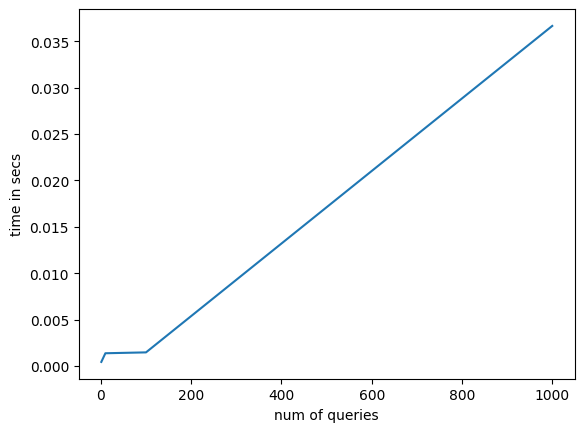

In [64]:
plt.plot(n_queries,times);
plt.xlabel('num of queries')
plt.ylabel('time in secs');

In [65]:
start_time = time.time()
paraphrases = util.paraphrase_mining(
  model, corpus_questions[:1000], show_progress_bar=True
)
end_time = time.time()

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

In [66]:
len(paraphrases)

71495

In [67]:
for score, i, j in paraphrases[:5]:
  print("{:.3f}\t{} and {}".format(score, corpus_questions[i], corpus_questions[j]))

0.991	Where can I get eco friendly pest control service in Australia? and Where can I get commercial pest control service in Australia?
0.981	Are there any bad effects of daily masturbation? and Is excessive masturbation dangerous?
0.966	Why has China been leading the world in patent filing, over 1.1 m patent filing in 2015 alone? and Why are Chinese so creative and innovative with IP filing over 1.1 m filing registration alone in year 2015 and leading the world again?
0.965	What steps could be taken to develop the indian constitution? and How do I read the constitution of India?
0.965	Why am I so good-looking? and Why do we want to look good?
